In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
from tqdm import tqdm

from tsmoothie.smoother import *
import pandas as pd

In [2]:
df = pd.read_csv(r'C:\Users\dheer\Desktop\AnomalyDetection\AAPL.csv')
df.tail()

,Date,AdjClose
751,07/05/2021,130.210007
752,10/05/2021,126.849998
753,11/05/2021,125.910004
754,12/05/2021,122.769997
755,13/05/2021,124.970001


In [3]:
data = np.array(df['AdjClose'], ndmin = 2)

### SLIDING WINDOW PARAMETER ###
timesteps = df['AdjClose'].count()

window_len = int(timesteps/20)

series = defaultdict(partial(np.ndarray, shape=(1,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    if i>window_len:
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])
        
        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]])
        
        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2.5)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])
        
        is_anomaly = np.logical_or(
                series['original'][:,-1] > series['up'][:,-1], 
                series['original'][:,-1] < series['low'][:,-1]
            ).reshape(-1,1)
        
        if is_anomaly.any():
                series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
                
    if i>=timesteps:
            continue
            
    series['original'] = np.hstack([series['original'], data[:,[i]]])

100%|██████████| 757/757 [00:00<00:00, 2119.14it/s]


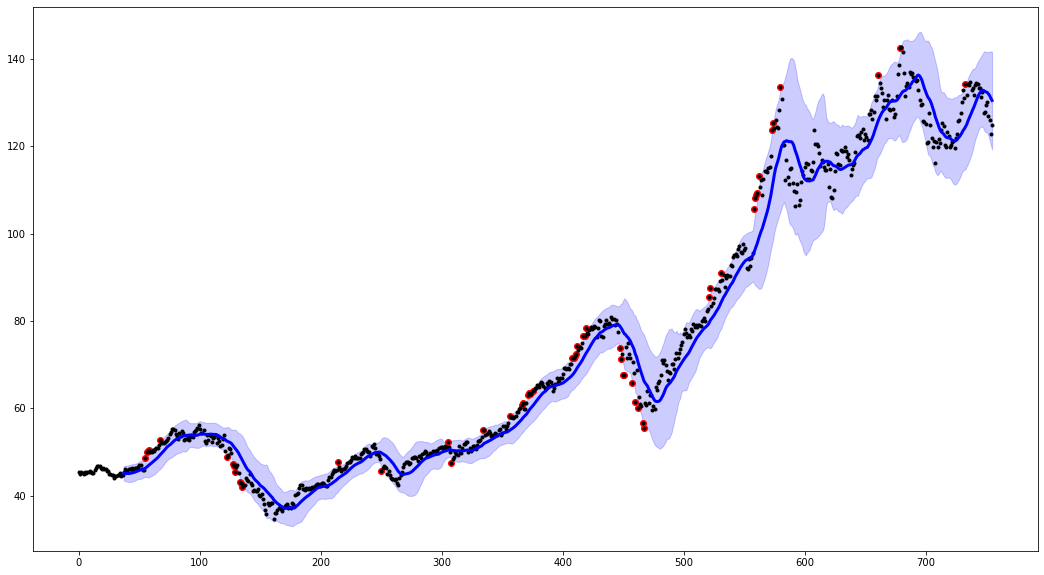

In [4]:
n_series = 1
fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    posrange = np.arange(window_len,timesteps)
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    ax.fill_between(posrange,
                   series['low'][i,1:], series['up'][i,1:],
                   color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    ano_id = ano_id[(ano_id >= 0) & (ano_id <= timesteps)]
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], c='red', alpha=1.)